<a href="https://colab.research.google.com/github/nshan-b/sa-workbook/blob/main/sa_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Sentiment Analysis</h1>
<p>This is the "final" version after a lot of testing with my SentimentAnalysisTry01.ipynb on colab.</p>
<h2>Overview of steps involved for Sentiment Analysis:</h2>
<ul>
    <li>1. Preprocess the data</li>
    <li>2. Create word embeddings</li>
    <li>3. Define the model architecture</li>
    <li>4. Train the model</li>
    <li>5. Test the model</li>
<ul>


<h3>Import everything</h3>

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
import re
from numpy.random import RandomState
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Sanity Check
!pip list | grep -F tensorflow

tensorflow                    2.8.2+zzzcolab20220527125636
tensorflow-datasets           4.0.1
tensorflow-estimator          2.8.0
tensorflow-gcs-config         2.8.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.26.0
tensorflow-metadata           1.8.0
tensorflow-probability        0.16.0


<h3>Let's go</h3>

In [ ]:
## Cleaning Functions
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

# Get data & remove missing values
all_data = pd.read_csv("./data/sa_160k_twitter_normalized.csv", encoding="latin-1", engine="python", on_bad_lines="skip")
all_data = all_data.dropna()

# Shuffle all data
rng = RandomState()
all_data = all_data.sample(frac=1, random_state=rng)
all_data.reindex(np.random.permutation(all_data.index))
all_data = all_data[['target', 'text']]

In [ ]:
## Use this to clean data
# all_data.text = all_data.text.apply(remove_stopwords).apply(remove_mentions)

In [ ]:
# Split data 70/30
X_train, X_test, y_train, y_test = train_test_split(all_data.text, all_data.target, test_size=0.3, random_state=rng)

print('# Train data samples:', X_train.shape)
print('# Test data samples:', X_test.shape)
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]



# Train data samples: (1117308,)
# Test data samples: (478847,)


In [ ]:
## WARNING - Vulgar tweets
print(X_train.head(n=5))
print(y_train.head(n=5))
print(X_test.head(n=5))
print(y_test.head(n=5)) 

1487446    Mornin tweeps...this day Lord made. Rejoice gl...
994181     feeling like I'm getting flu...just time weeke...
476281                          That Frisker car goooorgeous
1320042    *breathes* I'm mood destroy things .. teeth. a...
705913               http://twitpic.com/6comx It still does.
Name: text, dtype: object
1487446    4
994181     0
476281     4
1320042    4
705913     4
Name: target, dtype: int64
536062    thinking needs stop playing around twitter wor...
593988    This much know true, god bless broken road, le...
453776    almost tweetdeck locked yet.. maybe new versio...
834495    im losing sanity ive still got rest night go help
948923                                    300th update. lol
Name: text, dtype: object
536062    0
593988    4
453776    4
834495    0
948923    4
Name: target, dtype: int64


In [ ]:
# Set Word Limit & Word Vector of Integer Limit  
NUM_WORDS = 50000


# Convert words to numbers
tk = Tokenizer(num_words=NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True, split=" ")

tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

# Split by a space for each list of sequences
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
print(seq_lengths.describe())

seq_lengths.max

# Ideally - the above .describe() will tell you the max sequence to set MAX_LEN to
MAX_LEN = int(max(seq_lengths))

# Pad sequences to MAX_LEN e.g. [0, 0, ... 38, 172]
X_train_seq_trunc = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=MAX_LEN)

# Example of a padded sequence
print("=======\n Padded sequence:")
print(X_train_seq_trunc[5])

# Convert labels to numeric vectors
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

y_train_new = tf.keras.utils.to_categorical(y_train_le)
y_test_new = tf.keras.utils.to_categorical(y_test_le)

print("=======\n Labels of y_train:")
print(y_train_new)



count    1.117308e+06
mean     8.361059e+00
std      4.236884e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.100000e+01
max      4.100000e+01
Name: text, dtype: float64
 Padded sequence:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0   28   27 9923 1961 1821  198 6886]
 Labels of y_train:
[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [ ]:
print(max(seq_lengths))

41


In [ ]:
# Use this to save the word listing
def save_words(basic=True):
    word_list = pd.DataFrame(tk.index_word.items())
    word_list = word_list.rename(columns={0: "Encoding", 1: "Word"})
    if basic:
        word_list.to_csv("./data/basic_model/word_list.csv", index=False)
    else:
        word_list.to_csv("./data/newer_model/word_list.csv", index=False)

# WARNING - possible vulgarity (not my fault okay)
# Quick view of word listing
print(pd.DataFrame(tk.index_word.items()))
save_words(basic=False)

             0             1
0            1           i'm
1            2           not
2            3          good
3            4           day
4            5           get
...        ...           ...
297754  297755      lastweeg
297755  297756  unemployable
297756  297757       belanje
297757  297758          molo
297758  297759         hemat

[297759 rows x 2 columns]


In [ ]:
# Split off validation data
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_new,
                                                                      test_size=0.3, random_state=rng)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape, y_valid_emb.shape)

Shape of validation set: (335193, 41) (335193, 2)


In [ ]:
# Create our model functions
def create_basic_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(NUM_WORDS, 64, input_length=MAX_LEN))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=8, activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(10, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print('Basic Model Summary')
    model.summary()
    return model

def create_new_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Embedding(NUM_WORDS, 128, input_length=MAX_LEN))
    model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(rate=0.4))
    model.add(tf.keras.layers.Dense(75, activation='relu'))
    model.add(tf.keras.layers.Dense(2, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print('New Model Summary')
    model.summary()
    return model


In [ ]:
# Use our models

NUM_EPOCHS = 7
BATCH_SIZE = 1024

def train_model(model):
    history = model.fit(X_train_emb, y_train_emb, epochs=NUM_EPOCHS, 
                    batch_size=BATCH_SIZE, validation_data=(X_valid_emb, y_valid_emb), 
                    verbose=True)
    return history

# New Model Training
nm = create_new_model()
nm_history = train_model(nm)
results = nm.evaluate(X_test_seq_trunc, y_test_new)

# Basic Model Training
# bm = create_basic_model()
# bm_history = train_model(bm)
# results = bm.evaluate(X_test_seq_trunc, y_test_new)
print('Test accuracy of model: {0:.2f}%'.format(results[1]*100))

New Model Summary
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 128)           6400000   
                                                                 
 conv1d_3 (Conv1D)           (None, 41, 16)            6160      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 20, 16)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 20, 32)            1568      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 10, 32)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 

In [ ]:
# Do an example prediction
example_sentences = np.array(["omg I love applebees",
    "omg I hate applebees",
     "thank you!", 
     "there's no I in team",
     "who is this",
])
example_sentences = tk.texts_to_sequences(example_sentences)
example_sentences = tf.keras.preprocessing.sequence.pad_sequences(example_sentences, maxlen=MAX_LEN)

prediction = nm.predict(example_sentences)
# prediction = bm.predict(example_sentences)
print(prediction)



[[0.24482092 0.755062  ]
 [0.9865339  0.0141837 ]
 [0.02239516 0.9773189 ]
 [0.11081693 0.8889638 ]
 [0.309542   0.6905417 ]]


In [ ]:
# Save new model (non-colab)
nm.save("./data/newer_model")

INFO:tensorflow:Assets written to: ./data/newer_model/assets


In [ ]:
# Save basic model (non-colab):
bm.save("./data/basic_model")
# optionally save words
save_words(basic=True)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('model',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('model',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('model',), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:tensorflow:Assets written to: ./data/basic_model\assets


INFO:tensorflow:Assets written to: ./data/basic_model\assets


In [ ]:
# Tokenize function to convert sentence to integer array of max_len
def tokenize(sentence, max_len, encoding):
    token_vector = np.zeros(max_len)
    for i, word in enumerate(sentence.split(" ")):
        # print(f"{i} - {word}")
        if i >= max_len:
            break
        if word in encoding.keys():
            token_vector[max_len - i - 1] = encoding[word]
        else:
            token_vector[max_len - i - 1] = 0
    # print(token_vector)
    return token_vector

In [ ]:
# Load the basic model and use it for inference
loaded_nm = tf.keras.models.load_model("./data/newer_model")
#loaded_bm = tf.keras.models.load_model("./data/basic_model")


my_word_list = pd.read_csv("./data/newer_model/word_list.csv", encoding="latin-1", engine="python", on_bad_lines="skip")
# my_word_list = pd.read_csv("./data/basic_model/word_list.csv", encoding="latin-1", engine="python", on_bad_lines="skip")
encoding = dict(zip(my_word_list["Word"], my_word_list["Encoding"]))

# Use here
# MAX_LEN = 35

new_examples = np.array([
    tokenize("I love this place!", MAX_LEN, encoding),
    tokenize("I hate this place!", MAX_LEN, encoding),
    tokenize("surf's up dude", MAX_LEN, encoding),
    tokenize("you snooze you lose", MAX_LEN, encoding),
])

print(new_examples.shape)
print(new_examples.dtype)


# Predict!
loaded_nm.predict(new_examples)
#loaded_bm.predict(new_examples)

(4, 41)
float64


array([[0.05943903, 0.9402803 ],
       [0.9230387 , 0.07883936],
       [0.22703773, 0.7744856 ],
       [0.15326372, 0.8472514 ]], dtype=float32)

In [ ]:
# Convert keras model to onnx
import onnx
import tensorflow
import keras2onnx

model_name_onnx = "new_model.onnx"
onnx_model = keras2onnx.convert_keras(loaded_nm, loaded_nm.name)
onnx.save_model(onnx_model, model_name_onnx)


AttributeError: ignored

In [ ]:
# Convert model to onnx
import tf2onnx
import onnx

input_signature = [tf.TensorSpec([1,41], tf.float64, name='x')]
onnx_model, _ = tf2onnx.convert.from_keras(loaded_nm, input_signature, opset=13)
onnx.save(onnx_model, "data/newer_model/newer_model.onnx")


In [ ]:
from google.colab import files
import os

dir_to_zip = './data/newer_model' #@param {type: "string"}
output_filename = 'newer_model.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Freeze? (not necessary - using ONNX now)
from keras import backend as K
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.
    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.compat.v1.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.compat.v1.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.compat.v1.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph
frozen_graph = freeze_session(K.get_session())
tf.compat.v1.train.write_graph(frozen_graph, "./new_data", "my_model.pb", as_text=False)

'./new_data/my_model.pb'

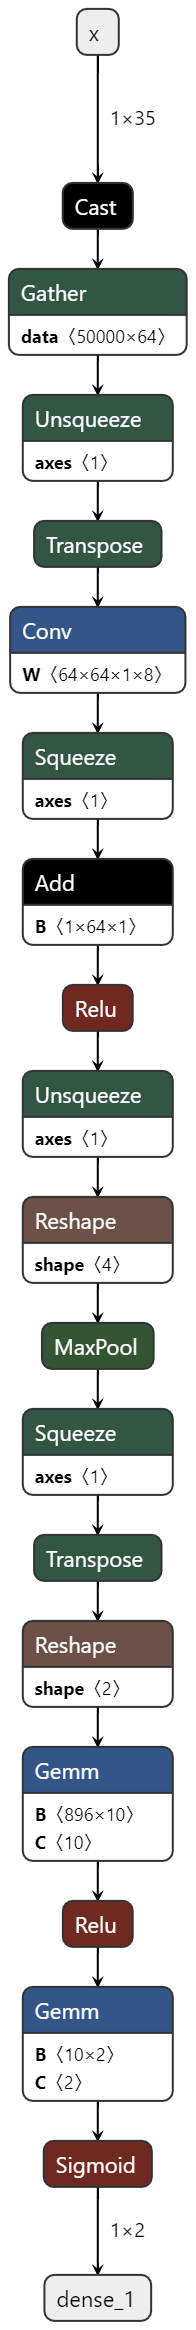